In [1]:
import numpy as np
import pandas as pd
from os import listdir
from os.path import isfile, join
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import cv2
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

### Choose Label Type and sample size

In [2]:
Labeltype = 'age'
samplesize = 5000

### Train test split imported data and balance train

In [3]:
# Import image labels and paths to dataframe
mypath = "../data/raw/CroppedImages/"
filenames = np.array([f for f in listdir(mypath) if isfile(join(mypath, f))])
splitcolumns = [x.split('_')[0:3] + [mypath + x] for x in filenames if x.count('_') == 3]
filecolumns = ['age','gender','race','file']
filedf = pd.DataFrame(data = splitcolumns, columns = filecolumns).astype({'age': 'int', 'gender': 'int', 'race': 'int'})

# Convert age to appropriate labels
filedf['age']=np.where((filedf.age<3), 0, filedf.age)
filedf['age']=np.where(((filedf.age>=3) & (filedf.age<6)), 1, filedf.age)
filedf['age']=np.where(((filedf.age>=6) & (filedf.age<9)), 2, filedf.age)
filedf['age']=np.where(((filedf.age>=9) & (filedf.age<12)), 3, filedf.age)
filedf['age']=np.where(((filedf.age>=12) & (filedf.age<21)), 4, filedf.age)
filedf['age']=np.where(((filedf.age>=21) & (filedf.age<36)), 5, filedf.age)
filedf['age']=np.where(((filedf.age>=36) & (filedf.age<51)), 6, filedf.age)
filedf['age']=np.where(((filedf.age>=51) & (filedf.age<80)), 7, filedf.age)
filedf['age']=np.where((filedf.age>=80), 8, filedf.age)

dfx = filedf.loc[:,'file']
dfy = filedf.loc[:,Labeltype]

# Get Train/Test
X_train, X_test, y_train, y_test = train_test_split(dfx, dfy, test_size=0.2, random_state=42)

# Get Train/Test/Validation dataset 0.25 * 8 = 0.2
X_train_2, X_val, y_train_2, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Encode training labels and initialize random over sampler
yencoded = LabelEncoder().fit_transform(y_train_2)
oversample = RandomOverSampler()

# Over sample until training classes are balanced
X_train_balanced, y_train_balanced = oversample.fit_resample(np.array(X_train_2).reshape(-1,1), yencoded)

# Of all classes, proportionally sample 10000
dxy = {'file': X_train_balanced.reshape(len(X_train_balanced)), 'label': y_train_balanced}
dfbalanced = pd.DataFrame(data = dxy)
balancedsamples = int(samplesize/len(set(dfbalanced.loc[:,'label'])))
dfbalancedsubset = dfbalanced.groupby('label', group_keys=False).apply(lambda x: x.sample(balancedsamples)).sample(frac=1)

### Count unbalanced, balanced, & balanced + sampled classes

In [4]:
# Count and print unbalanced classes
counter = Counter(y_train_2)
for k,v in counter.items():
    per = v / len(y_train_2) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

# Count and print balanced classes
counter = Counter(y_train_balanced)
for k,v in counter.items():
    per = v / len(y_train_balanced) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

# Count and print balanced classes subsets
counter = Counter(dfbalancedsubset.loc[:,'label'])
for k,v in counter.items():
    per = v / len(dfbalancedsubset.loc[:,'label']) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

Class=5, n=6093 (42.839%)
Class=2, n=331 (2.327%)
Class=6, n=2393 (16.825%)
Class=0, n=969 (6.813%)
Class=8, n=396 (2.784%)
Class=7, n=2405 (16.909%)
Class=3, n=231 (1.624%)
Class=4, n=954 (6.707%)
Class=1, n=451 (3.171%)
Class=5, n=6093 (11.111%)
Class=2, n=6093 (11.111%)
Class=6, n=6093 (11.111%)
Class=0, n=6093 (11.111%)
Class=8, n=6093 (11.111%)
Class=7, n=6093 (11.111%)
Class=3, n=6093 (11.111%)
Class=4, n=6093 (11.111%)
Class=1, n=6093 (11.111%)
Class=3, n=555 (11.111%)
Class=0, n=555 (11.111%)
Class=5, n=555 (11.111%)
Class=1, n=555 (11.111%)
Class=2, n=555 (11.111%)
Class=8, n=555 (11.111%)
Class=7, n=555 (11.111%)
Class=6, n=555 (11.111%)
Class=4, n=555 (11.111%)


### Function to get image data from urls

In [5]:
def get_images(filelist,rgb = True):
    dims = 0
    if(rgb):
        dims=3
    else:
        dims=1
    container = np.zeros((len(filelist),200,200,dims))
    for index,i in enumerate(filelist):
        img = cv2.imread(i)
        if(not rgb):
            img = color.rgb2gray(img)
        container[index,:,:,:dims]=img
    return container

### Image data of train,test, and validation

In [7]:
train_img_container = get_images(dfbalancedsubset.loc[:,'file'],rgb = True)
validation_img_container = get_images(X_val,rgb = True)
test_img_container = get_images(X_test,rgb = True)

### Flatten Images

In [8]:
train_img_container = train_img_container.reshape(len(train_img_container),200*200*3)
validation_img_container = validation_img_container.reshape(len(validation_img_container),200*200*3)
test_img_container = test_img_container.reshape(len(test_img_container),200*200*3)

### Get y values

In [9]:
y_train_label = dfbalancedsubset.loc[:,'label']
y_test = y_test
y_val = y_val

### Run to clear memory if necessary

In [ ]:
del train_img_container
del validation_img_container
del test_img_container
del CNNmodel

### Fit Classifier

In [12]:
KNN = KNeighborsClassifier(n_neighbors=3)
KNN.fit(train_img_container, y_train_label)

KNeighborsClassifier(n_neighbors=3)

### Get Predictions

In [13]:
ypredtrain = KNN.predict(train_img_container)
ypredtest = KNN.predict(test_img_container)
ypredval = KNN.predict(validation_img_container)

### Training Report

In [15]:
print(classification_report(ypredtrain,y_train_label))

              precision    recall  f1-score   support

           0       0.87      0.74      0.80       651
           1       0.86      0.76      0.81       634
           2       0.90      0.71      0.79       706
           3       0.92      0.79      0.85       649
           4       0.70      0.66      0.68       588
           5       0.46      0.69      0.55       368
           6       0.56      0.70      0.63       445
           7       0.52      0.72      0.61       402
           8       0.81      0.81      0.81       552

    accuracy                           0.73      4995
   macro avg       0.73      0.73      0.72      4995
weighted avg       0.77      0.73      0.74      4995



### Validation Report

In [16]:
print(classification_report(ypredval,y_val))

              precision    recall  f1-score   support

           0       0.64      0.39      0.49       508
           1       0.26      0.09      0.14       433
           2       0.23      0.04      0.07       541
           3       0.17      0.04      0.06       406
           4       0.20      0.10      0.13       676
           5       0.17      0.60      0.27       583
           6       0.21      0.24      0.22       679
           7       0.24      0.29      0.27       601
           8       0.26      0.12      0.16       314

    accuracy                           0.23      4741
   macro avg       0.26      0.21      0.20      4741
weighted avg       0.26      0.23      0.21      4741



### Testing Report

In [17]:
print(classification_report(ypredtest,y_test))

              precision    recall  f1-score   support

           0       0.62      0.34      0.44       606
           1       0.21      0.07      0.11       433
           2       0.21      0.04      0.07       571
           3       0.23      0.04      0.06       398
           4       0.18      0.09      0.12       627
           5       0.15      0.55      0.23       546
           6       0.20      0.24      0.22       651
           7       0.23      0.31      0.26       578
           8       0.27      0.11      0.15       331

    accuracy                           0.21      4741
   macro avg       0.26      0.20      0.19      4741
weighted avg       0.26      0.21      0.20      4741



In [18]:
labels = []
title = ''
if(Labeltype == 'age'):
    labels = ['0 infancy(0-2','1 Early Childhood(3-5)','2 Middle Childhood(6-8)','3 Late Childhood(9-11)','4 Adolescence(12-20)'
          ,'5 Early Adulthood(21-35)','6 Midlife(36-50)','7 Mature Adulthood(51-79)','8 Late Adulthood(80+)']
    title = 'Confusion Matrix for age '
if(Labeltype == 'race'):
    labels = ['0 White','1 Black','2 Asian','3 Indian','4 Other']
    title = 'Confusion Matrix for race '
if(Labeltype == 'gender'):
    labels = ['0 Male','1 Female']
    title = 'Confusion Matrix for age '

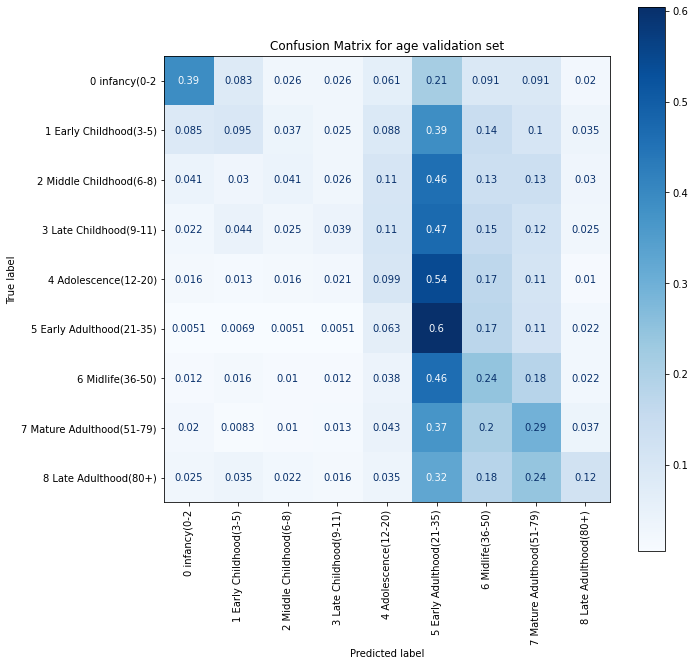

In [21]:
cm = confusion_matrix(ypredval,y_val,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues,ax=ax)
plt.title(title + 'validation set')
plt.xticks(rotation = 90)
plt.show()

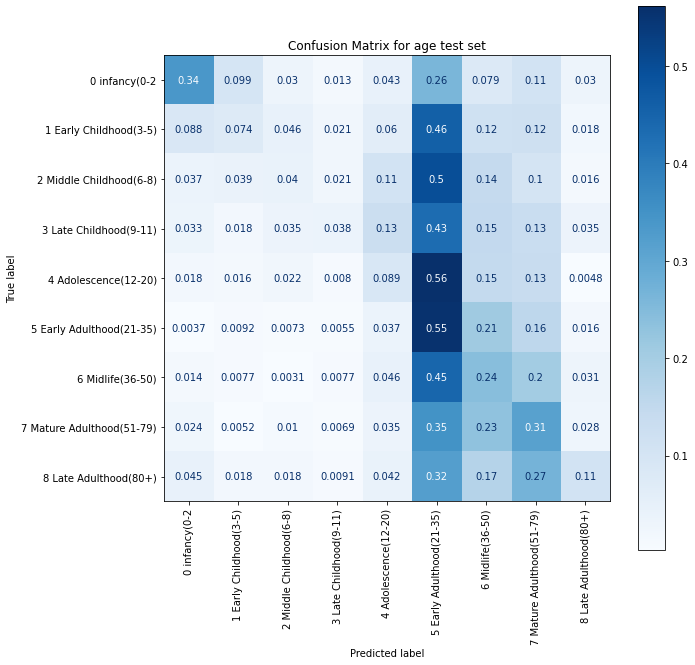

In [23]:
cm = confusion_matrix(ypredtest,y_test,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues,ax=ax)
plt.title(title + 'test set')
plt.xticks(rotation = 90)

plt.show()
plt.show()